In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from src.env.dunderbot_env import DunderBotEnv
import src.run as run
import src.load as load

loading config from config/config.yml
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# TODO:

- Add portfolio features (need to understand how to best format different types of observations in Box -- e.g., can I pad with 0:s/NaN:s?)
- Refactor `_take_action` (might be something off in some calculations, also update terminology)
- Refactor current reward and add some new ones
- Add reward output
- figure out how to normalize values properly
    * do we have to account for prediction as well? That is, can/should we predict using values outside of 0-1 range?
- understand the rendering, especially during learning
- Change policy network (need to understand terminology surronding it, e.g. envoronment, n_steps etc). See also discussion here (and elsewhere among Issues: https://github.com/hill-a/stable-baselines/issues/759)
- setup train/test functionality (separate reset functions? Multiple time periods for testing?)
- Check/Enable/Add exploration noise
- Understand how we should format observations, both for MLP and LSTM policy networks
- lock down the seeds (and decide in config from a few specific ones)
- setup performance output, what we need to make data driven decision
    *e.g. https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/master/1_getting_started.ipynb#scrollTo=63M8mSKR-6Zt
- Add benchmarks
- Find as long time series of BTCUSD hourly data as possible, quite shortright now
- Add smallest amount of bitcoin we can own, as well as trading precision
- Add finer temporal resolution in data (generate/download multiple granularity)
- Check float number type


# DONE: 
- add config
- modularize rewards
- own actions
- add more detailed actions for buy and sell amounts (still Discrete, I believe)
- wrap running code in function in main.py (to enable more dynamic data loading and train/test)
- own observations
- remove the bias when getting the observations (suggestion in the repo issues)
- download more interesting data and manually preprocess
- load interesting data, specified in config
- understand the time steps in learn and predict
- setup basic monitoring of training using TensorBoard
- Visualize basic performance
- Add support for fractions of shares
- Understand what should belong in what timestep (also decide on which price to plot as a result)
- add distributions of actions as output during prediction

# Run

In [5]:
%%time
df = load.load_OHLC_data()
env = run.preprocess(df=df)
model = run.train(env=env, total_timesteps=10000)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




--------------------------------------
| approxkl           | 5.815018e-05  |
| clipfrac           | 0.0           |
| explained_variance | -4.17e-06     |
| fps                | 163           |
| n_updates          | 1             |
| policy_entropy     | 2.197167      |
| policy_loss        | -0.0014634391 |
| serial_timesteps   | 128           |
| time_elapsed       | 0.000344      |
| total_timesteps    | 128           |
| value_loss         | 64927.945     |
--------------------------------------
-------------------------------------
| approxkl           | 0.0012056113 |
| clipfrac           | 0.0          |
| explained_variance | -1.62e-05    |
| fps                | 292          |
| n_updates          | 10           |
| policy_entropy     | 2.1

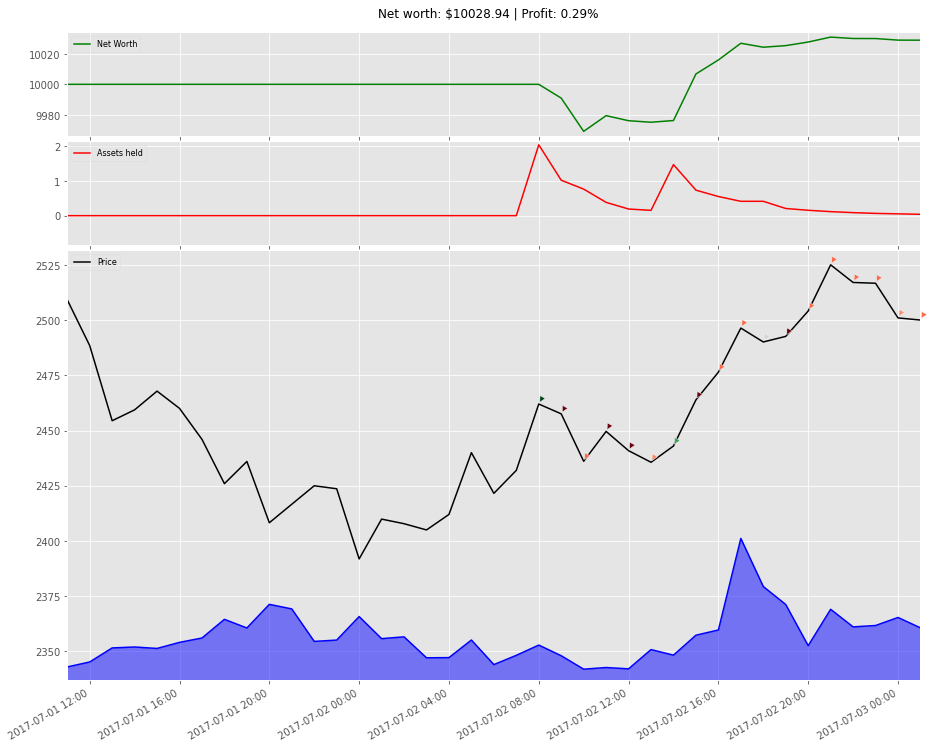

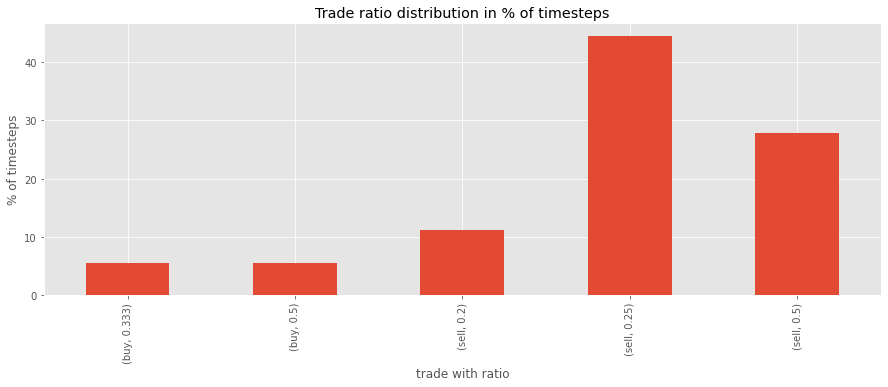

CPU times: user 2.12 s, sys: 62.9 ms, total: 2.18 s
Wall time: 2.18 s


In [7]:
%%time
run.predict(env=env, model=model, total_timesteps=30, rendermode='human')

In [162]:
import pickle
with open('all_dict_pred.pickle', 'rb') as f:
    x = pickle.load(f)
x

{'current_step': 3009,
 'net_worths': [10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  7500.0,
  6000.0,
  6000.0,
  6000.0,
  6000.0,
  6000.0,
  6000.0,
  6000.0,
  6000.0,
  6000.0,
  6000.0,
  6000.0,
  6000.0,
  6000.0,
  6000.0,
  6000.0,
  6000.0

In [139]:
x.keys()

dict_keys(['current_step', 'net_worths', 'trades', 'shares_held_hist'])